# 掛載雲端硬碟

前處理完畢檔案之路徑：

/content/drive/MyDrive/AI CUP/多模態病理嗓音分類競賽/Training Dataset/Preprocessed Data/testData_0505.csv

/content/drive/MyDrive/AI CUP/多模態病理嗓音分類競賽/Training Dataset/Preprocessed Data/trainData_0505.csv

In [ ]:
import os
from google.colab import drive

drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/AI CUP/多模態病理嗓音分類競賽')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 載入套件

In [ ]:
import numpy as np
import pandas as pd
import librosa

import tensorflow as tf
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, LayerNormalization
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics, svm
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, roc_curve, auc, accuracy_score
#---#

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output

# 載入訓練資料

已切分好train&test(9:1)

In [ ]:
# 讀取訓練資料集
# source_df = pd.read_csv('./Training Dataset/trainingData_preprocessed.csv')
training_df = pd.read_csv('./Training Dataset/Preprocessed Data/trainData_0505.csv')
test_df = pd.read_csv('./Training Dataset/Preprocessed Data/testData_0505.csv')
# 刪除索引
# source_df=source_df.drop(['Unnamed: 0','ID'],axis=1)
training_df=training_df.drop(['Unnamed: 0','ID'],axis=1)
test_df=test_df.drop(['Unnamed: 0','ID'],axis=1)
# 顯示資訊
# print('source_df.shape :', source_df.shape)
# print('source_df.columns :', source_df.columns)
print('training_df.shape :', training_df.shape)
print('training_df.columns :', training_df.columns)
print('------')
print('test_df.shape :', test_df.shape)
print('test_df.columns :', test_df.columns)

training_df.shape : (900, 30)
training_df.columns : Index(['Sex', 'Age', 'Disease category', 'Narrow pitch range',
       'Decreased volume', 'Fatigue', 'Dryness', 'Lumping', 'heartburn',
       'Choking', 'Eye dryness', 'PND', 'Smoking', 'PPD', 'Drinking',
       'frequency', 'Onset of dysphonia ', 'Noise at work',
       'Occupational vocal demand', 'Diabetes', 'Hypertension', 'CAD',
       'Head and Neck Cancer', 'Head injury', 'CVA',
       'Voice handicap index - 10', 'Diurnal pattern_1', 'Diurnal pattern_2',
       'Diurnal pattern_3', 'Diurnal pattern_4'],
      dtype='object')
------
test_df.shape : (100, 30)
test_df.columns : Index(['Sex', 'Age', 'Disease category', 'Narrow pitch range',
       'Decreased volume', 'Fatigue', 'Dryness', 'Lumping', 'heartburn',
       'Choking', 'Eye dryness', 'PND', 'Smoking', 'PPD', 'Drinking',
       'frequency', 'Onset of dysphonia ', 'Noise at work',
       'Occupational vocal demand', 'Diabetes', 'Hypertension', 'CAD',
       'Head and Nec

# 切分訓練集與測試集

In [ ]:
# training_df, test_df = train_test_split(source_df, test_size=0.1, random_state=333)
# print('training_df shape :', training_df.shape, ', test_df shape :', test_df.shape)

In [ ]:
# training_df.to_csv('./Training Dataset/train_data.csv',index=False)
# test_df.to_csv('./Training Dataset/test_data.csv',index=False)

In [ ]:
# 訓練資料標記轉換
# training_data = training_df.iloc[:, :-1] # 刪除VHI-10嗓音障礙指標
training_data = training_df.drop(['Voice handicap index - 10'], axis=1) # 刪除VHI-10嗓音障礙指標
training_data['c1'] = training_data['Disease category'].map({1:1, 2:0, 3:0, 4:0, 5:0})
training_data['c2'] = training_data['Disease category'].map({1:0, 2:1, 3:0, 4:0, 5:0})
training_data['c3'] = training_data['Disease category'].map({1:0, 2:0, 3:1, 4:0, 5:0})
training_data['c4'] = training_data['Disease category'].map({1:0, 2:0, 3:0, 4:1, 5:0})
training_data['c5'] = training_data['Disease category'].map({1:0, 2:0, 3:0, 4:0, 5:1})
training_label = (training_data['Disease category']-1).to_frame()
training_data = training_data.drop(['Disease category'], axis=1)
print('training_data.shape :', training_data.shape)

x_train = training_data.iloc[:, :-5]
y_train = training_data.iloc[:, -5:]
# x_train = training_data.drop(['Disease category'], axis=1)
# y_train = training_data.iloc[:, 2:3]
print('x_train.shape, y_train.shape :', x_train.shape, y_train.shape)
print('y_train.columns :', y_train.columns.tolist())

training_data.shape : (900, 33)
x_train.shape, y_train.shape : (900, 28) (900, 5)
y_train.columns : ['c1', 'c2', 'c3', 'c4', 'c5']


In [ ]:
# 驗證資料標記轉換
# test_data = test_df.iloc[:, :-1] # 刪除VHI-10嗓音障礙指標
test_data = test_df.drop(['Voice handicap index - 10'], axis=1) # 刪除VHI-10嗓音障礙指標
test_data['c1'] = test_data['Disease category'].map({1:1, 2:0, 3:0, 4:0, 5:0})
test_data['c2'] = test_data['Disease category'].map({1:0, 2:1, 3:0, 4:0, 5:0})
test_data['c3'] = test_data['Disease category'].map({1:0, 2:0, 3:1, 4:0, 5:0})
test_data['c4'] = test_data['Disease category'].map({1:0, 2:0, 3:0, 4:1, 5:0})
test_data['c5'] = test_data['Disease category'].map({1:0, 2:0, 3:0, 4:0, 5:1})
test_label = (test_data['Disease category']-1).to_frame()
test_data = test_data.drop(['Disease category'], axis=1)
print('test_data.shape :', test_data.shape)

x_test = test_data.iloc[:, :-5]
y_test = test_data.iloc[:, -5:]
# x_test = test_data.drop(['Disease category'], axis=1)
# y_test = test_data.iloc[:, 2:3]
print('x_test.shape, y_test.shape :', x_test.shape, y_test.shape)
print('y_test.columns :', y_test.columns.tolist())

test_data.shape : (100, 33)
x_test.shape, y_test.shape : (100, 28) (100, 5)
y_test.columns : ['c1', 'c2', 'c3', 'c4', 'c5']


In [ ]:
test_data = test_df.drop(['Voice handicap index - 10'], axis=1) # 刪除VHI-10嗓音障礙指標
test_data

,Sex,Age,Disease category,Narrow pitch range,Decreased volume,Fatigue,Dryness,Lumping,heartburn,Choking,...,Diabetes,Hypertension,CAD,Head and Neck Cancer,Head injury,CVA,Diurnal pattern_1,Diurnal pattern_2,Diurnal pattern_3,Diurnal pattern_4
0,1.0,0.272727,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.285714,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.155844,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.298701,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.207792,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.389610,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
96,1.0,0.428571,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
97,1.0,0.272727,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
98,0.0,0.220779,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# 模型訓練

In [ ]:
!pip install catboost
!pip install ipywidgets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


不同分類器

In [ ]:
# # https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
# from itertools import combinations
# from sklearn.metrics import RocCurveDisplay
# from sklearn.metrics import roc_auc_score
# def multiclass_roc(classes, X_test, ):
#   plt.figure(figsize = (12, 8))
#   bins = [i/20 for i in range(20)] + [1]
#   # classes = model_multiclass.classes_
#   roc_auc_ovr = {}
#   for i in range(len(classes)):
#       # Gets the class
#       c = classes[i]
      
#       # Prepares an auxiliar dataframe to help with the plots
#       df_aux = X_test.copy()
#       df_aux['class'] = [1 if y == c else 0 for y in y_test]
#       df_aux['prob'] = y_proba[:, i]
#       df_aux = df_aux.reset_index(drop = True)
      
#       # Plots the probability distribution for the class and the rest
#       ax = plt.subplot(2, 3, i+1)
#       sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
#       ax.set_title(c)
#       ax.legend([f"Class: {c}", "Rest"])
#       ax.set_xlabel(f"P(x = {c})")
      
#       # Calculates the ROC Coordinates and plots the ROC Curves
#       ax_bottom = plt.subplot(2, 3, i+4)
#       tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
#       plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
#       ax_bottom.set_title("ROC Curve OvR")
      
#       # Calculates the ROC AUC OvR
#       roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])
#   plt.tight_layout()

In [ ]:
# def plot_roc_curve(tpr, fpr, scatter = True, ax = None):
#   '''
#   Plots the ROC Curve by using the list of coordinates (tpr and fpr).
  
#   Args:
#       tpr: The list of TPRs representing each coordinate.
#       fpr: The list of FPRs representing each coordinate.
#       scatter: When True, the points used on the calculation will be plotted with the line (default = True).
#   '''
#   if ax == None:
#       plt.figure(figsize = (5, 5))
#       ax = plt.axes()
  
#   if scatter:
#       sns.scatterplot(x = fpr, y = tpr, ax = ax)
#   sns.lineplot(x = fpr, y = tpr, ax = ax)
#   sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = ax)
#   plt.xlim(-0.05, 1.05)
#   plt.ylim(-0.05, 1.05)
#   plt.xlabel("False Positive Rate")
#   plt.ylabel("True Positive Rate")
# def get_all_roc_coordinates(y_real, y_proba):
#     '''
#     Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a threshold for the predicion of the class.
    
#     Args:
#         y_real: The list or series with the real classes.
#         y_proba: The array with the probabilities for each class, obtained by using the `.predict_proba()` method.
        
#     Returns:
#         tpr_list: The list of TPRs representing each threshold.
#         fpr_list: The list of FPRs representing each threshold.
#     '''
#     tpr_list = [0]
#     fpr_list = [0]
#     for i in range(len(y_proba)):
#         threshold = y_proba[i]
#         y_pred = y_proba >= threshold
#         tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
#         tpr_list.append(tpr)
#         fpr_list.append(fpr)
#     return tpr_list, fpr_list

In [ ]:
# https://blog.csdn.net/Einsteintly/article/details/109680218
# 重要特徵排序
def ranking_features(clf_name,cm,clf):
  if clf_name == 'XGBClassifier':
    fig,ax = plt.subplots(figsize=(16,9))
    from xgboost import plot_importance, to_graphviz
    plot_importance(clf,height=0.5,importance_type='gain',xlabel=clf_name+'_import_feature_names',grid=False,ax=ax)
    to_graphviz(clf,num_trees=1,yes_color='#638e5e',no_color='#a40000')
  elif clf_name == 'CatBoostClassifier':
    fea_ = clf.feature_importances_
    fea_name = clf.feature_names_
    plt.figure(figsize=(16, 9))
    plt.title('catboost算法计算出的与留存相关特征重要性')
    plt.barh(fea_name,fea_,height =0.5)

In [ ]:
# roc_curve, auc
def result(X_train,y_train,clf,pred,y_test,X_test,clf_name):
  # (X_train,y_train,forest,pred,y_test)
  # cv=10

  print('----------training----------')
  y_pred=clf.predict(X_train)
  # train_recall = cross_val_score(clf, X_train, y_train, cv=cv, scoring='recall').mean()
  train_recall = recall_score(y_train, y_pred, average=None)
  print('Training UAR(Unweighted Average Recall) :', train_recall.mean())
  train_accuracy = accuracy_score(y_train, y_pred)
  print('Training UAR(Unweighted Accuracy) :', train_accuracy)
  if(len(y_pred[0])>1):
    y_train_encoding=y_train.to_numpy()
    y_train_label = np.argmax(y_train_encoding, axis=1)
    y_pred_label = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_train_label, y_pred_label)
    
  else:
    cm = confusion_matrix(y_train, y_pred)
  ConfusionMatrixDisplay(cm).plot(cmap='Blues')

  print('----------test----------')
  test_recall = metrics.recall_score(y_test, pred, average=None)
  print('Testing UAR(Unweighted Average Recall) :', test_recall.mean())
  test_accuracy = accuracy_score(y_test, pred)
  print('Testing UAR(Unweighted Accuracy) :', test_accuracy)
  if(len(pred[0])>1):
    y_test_encoding=y_test.to_numpy()
    y_test_label = np.argmax(y_test_encoding, axis=1)
    pred_label = np.argmax(pred, axis=1)
    cm = confusion_matrix(y_test_label, pred_label)
  else:
    cm = confusion_matrix(y_test, pred)
  # TN = cm[0, 0]
  # FP = cm[0, 1]
  # FN = cm[1, 0]
  # TP = cm[1, 1]
  
  # # Calculates tpr and fpr
  # tpr =  TP/(TP + FN) # sensitivity - true positive rate
  # fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate
  ConfusionMatrixDisplay(cm).plot(cmap='Blues')

  new= pd.DataFrame.from_dict({
      'train_Re':[train_recall],
      'test_Re':[test_recall]
      })
  # from sklearn.metrics import RocCurveDisplay

  # y_proba = clf.predict_proba(X_test)
  # classes = clf.classes_
  # plt.figure(figsize = (12, 8))
  # bins = [i/20 for i in range(20)] + [1]
  # roc_auc_ovr = {}

  # for i in range(len(classes)):
  #   # Gets the class
  #   c = classes[i]
    
  #   # Prepares an auxiliar dataframe to help with the plots
  #   df_aux = X_test.copy()
  #   df_aux['class'] = [1 if y == c else 0 for y in y_test]
  #   df_aux['prob'] = y_proba[:, i]
  #   df_aux = df_aux.reset_index(drop = True)
    
  #   # Plots the probability distribution for the class and the rest
  #   ax = plt.subplot(2, 3, i+1)
  #   sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
  #   ax.set_title(c)
  #   ax.legend([f"Class: {c}", "Rest"])
  #   ax.set_xlabel(f"P(x = {c})")
    
  #   # Calculates the ROC Coordinates and plots the ROC Curves
  #   ax_bottom = plt.subplot(2, 3, i+4)
  #   tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
  #   plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
  #   ax_bottom.set_title("ROC Curve OvR")
    
  #   # Calculates the ROC AUC OvR
  #   roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])
      
  # plt.tight_layout()
  if clf_name in ['XGBClassifier' ,'CatBoostClassifier']:
    ranking_features(clf_name,cm,clf)
  return new

def runclf(X_train,y_train,X_test,y_test, training_label, test_label):
  # 改變分類器s n r l g
  svm_new=s(X_train,y_train,X_test,y_test)
  nb_new=n(X_train,y_train,X_test,y_test)
  rf_new=r(X_train,y_train,X_test,y_test)
  lr_new=l(X_train,y_train,X_test,y_test)
  df_new=df(X_train,y_train,X_test,y_test)
  xgb_new=g(X_train,y_train,X_test,y_test)
  # xgbr_new=gr(X_train,y_train,X_test,y_test)
  # catboost不用預處理label
  cat_new=cb(X_train,training_label,X_test,test_label)
  # catr_new=cbr(X_train,training_label,X_test,test_label)
  
  set_new=pd.concat([svm_new, nb_new, rf_new, lr_new, df_new, xgb_new, cat_new],axis=1)
  return set_new

In [ ]:
def s(X_train,y_train,X_test,y_test):
  # https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-create-a-multilabel-svm-classifier-with-scikit-learn.md
  from sklearn.multioutput import MultiOutputClassifier
  print('svm')
  svm=SVC(probability=True)
  # Make it an Multilabel classifier
  multilabel_classifier = MultiOutputClassifier(svm, n_jobs=-1)
  # svm.fit(X_train,y_train)
  multilabel_classifier.fit(X_train, y_train)
  pred=multilabel_classifier.predict(X_test)
  return result(X_train,y_train,multilabel_classifier,pred,y_test,X_test,'SVM')

def n(X_train,y_train,X_test,y_test):
  from sklearn.naive_bayes import GaussianNB
  from sklearn.multioutput import MultiOutputClassifier
  print('NB')
  nb = GaussianNB()
  # Make it an Multilabel classifier
  multilabel_classifier = MultiOutputClassifier(nb, n_jobs=-1)
  multilabel_classifier.fit(X_train,y_train)
  pred=multilabel_classifier.predict(X_test)
  return result(X_train,y_train,multilabel_classifier,pred,y_test,X_test,'GaussianNB')

def r(X_train,y_train,X_test,y_test):
  from sklearn import ensemble
  print('RF')
  forest = ensemble.RandomForestClassifier(n_estimators = 100)
  forest.fit(X_train,y_train)
  pred=forest.predict(X_test)
  return result(X_train,y_train,forest,pred,y_test,X_test,'RandomForestClassifier')

def l(X_train,y_train,X_test,y_test):
  from sklearn.multioutput import MultiOutputClassifier
  from sklearn.linear_model  import LogisticRegression
  print('LR')
  lr=LogisticRegression()
  multilabel_classifier = MultiOutputClassifier(lr, n_jobs=-1)
  multilabel_classifier.fit(X_train,y_train)
  pred=multilabel_classifier.predict(X_test)
  return result(X_train,y_train,multilabel_classifier,pred,y_test,X_test,'LogisticRegression')
def df(X_train,y_train,X_test,y_test):
  from sklearn import tree
  print('DecisionTree')
  DecisionTree = tree.DecisionTreeClassifier()
  DecisionTree.fit(X_train,y_train)
  pred=DecisionTree.predict(X_test)
  return result(X_train,y_train,DecisionTree,pred,y_test,X_test,'DecisionTreeClassifier')
def g(X_train,y_train,X_test,y_test):
  print('XGBClassifier')
  from sklearn import metrics
  from xgboost.sklearn import XGBClassifier
  XGB = XGBClassifier()
  XGB.fit(X_train,y_train)
  pred=XGB.predict(X_test)
  return result(X_train,y_train,XGB,pred,y_test,X_test,'XGBClassifier')
# def gr(X_train,y_train,X_test,y_test):
#   print('XGBRegressor')
#   from xgboost import XGBRegressor
#   XGB = XGBRegressor()
#   XGB.fit(X_train,y_train)
#   pred=XGB.predict(X_test)
#   print('pred')
#   print(pred)
#   return result(X_train,y_train,XGB,pred,y_test,X_test)
def cb(X_train,y_train,X_test,y_test):
  print('CatBoostClassifier')
  from catboost import CatBoostClassifier
  CAT = CatBoostClassifier()
  CAT.fit(X_train,y_train, verbose=0, plot=True)
  pred=CAT.predict(X_test)
  return result(X_train,y_train,CAT,pred,y_test,X_test,'CatBoostClassifier')
# def cbr(X_train,y_train,X_test,y_test):
#   print('CatBoostRegressor')
#   from catboost import CatBoostRegressor
#   CAT = CatBoostRegressor()
#   CAT.fit(X_train,y_train, verbose=0, plot=True)
#   pred=CAT.predict(X_test)
#   return result(X_train,y_train,CAT,pred,y_test,X_test)

# def cbr(X_train,y_train,X_test,y_test):
#   # https://ithelp.ithome.com.tw/articles/10275263
#   from catboost import CatBoostRegressor
#   print('CatBoostRegressor')
#   CAT = CatBoostRegressor(random_state=42,loss_function='RMSE',eval_metric='RMSE',use_best_model=True)
#   CAT.fit(X_train,y_train, eval_set=(X_test, y_test), verbose=0, plot=True)
#   pred=CAT.predict(X_test)
#   return result(X_train,y_train,CAT,pred,y_test)
# def cbr(X_train,y_train,X_test,y_test):
#   # https://www.kaggle.com/code/kgxiao/comparison-of-catboost-and-one-hot-encoding
#   from catboost import CatBoostRegressor
#   print('CatBoostRegressor')
#   CAT = CatBoostRegressor(n_estimators=1000, learning_rate=0.05, loss_function='MultiRMSE', eval_metric='MultiRMSE')
#   CAT.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_test, y_test)], verbose=False, plot=True)
  
#   pred = CAT.predict(X_test)
#   # return result(X_train,y_train,CAT,pred,y_test)
#   return 'CATR OK'
# def gr(X_train,y_train,X_test,y_test):
#   # https://www.kaggle.com/code/ankitkuls/xgboost-with-one-hot-encoding/notebook
#   from xgboost import XGBRegressor
#   print('XGBRegressor')
#   XGB = XGBRegressor(n_estimators=1000, learning_rate=0.05)
#   XGB.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_test, y_test)], verbose=False)

#   pred = XGB.predict(X_test)
#   max_estimators = len(XGB.evals_result()['validation_0']['rmse'])
#   print(max_estimators)
#   pd.DataFrame(XGB.evals_result()['validation_0']['rmse'], columns=['rmse']).plot()
#   # return result(X_train,y_train,XGB,pred,y_test)
#   return 'XGBR OK'

svm
----------training----------
Training UAR(Unweighted Average Recall) : 0.3068201064781092
Training UAR(Unweighted Accuracy) : 0.5811111111111111
----------test----------
Testing UAR(Unweighted Average Recall) : 0.24285714285714283
Testing UAR(Unweighted Accuracy) : 0.59
NB
----------training----------
Training UAR(Unweighted Average Recall) : 0.7928304937196866
Training UAR(Unweighted Accuracy) : 0.0044444444444444444
----------test----------
Testing UAR(Unweighted Average Recall) : 0.7148809523809524
Testing UAR(Unweighted Accuracy) : 0.0
RF
----------training----------
Training UAR(Unweighted Average Recall) : 1.0
Training UAR(Unweighted Accuracy) : 1.0
----------test----------
Testing UAR(Unweighted Average Recall) : 0.26607142857142857
Testing UAR(Unweighted Accuracy) : 0.61
LR
----------training----------
Training UAR(Unweighted Average Recall) : 0.29069412120027716
Training UAR(Unweighted Accuracy) : 0.5311111111111111
----------test----------
Testing UAR(Unweighted Average R

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----------training----------
Training UAR(Unweighted Average Recall) : 1.0
Training UAR(Unweighted Accuracy) : 1.0
----------test----------
Testing UAR(Unweighted Average Recall) : 0.4565476190476191
Testing UAR(Unweighted Accuracy) : 0.8


/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 31639 (\N{CJK UNIFIED IDEOGRAPH-7B97}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 27861 (\N{CJK UNIFIED IDEOGRAPH-6CD5}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 35745 (\N{CJK UNIFIED IDEOGRAPH-8BA1}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 20986 (\N{CJK UNIFIED IDEOGRAPH-51FA}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 19982 (\N{CJK UNIFIED IDEOGRAPH-4E

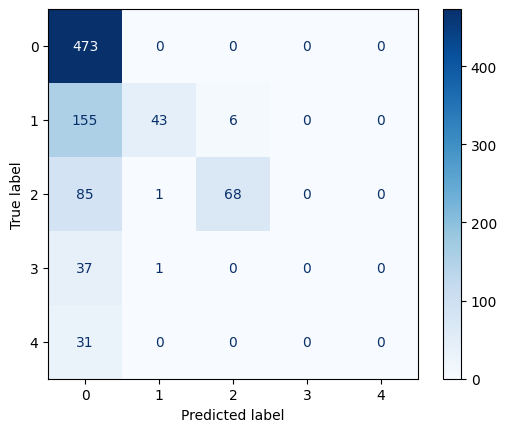

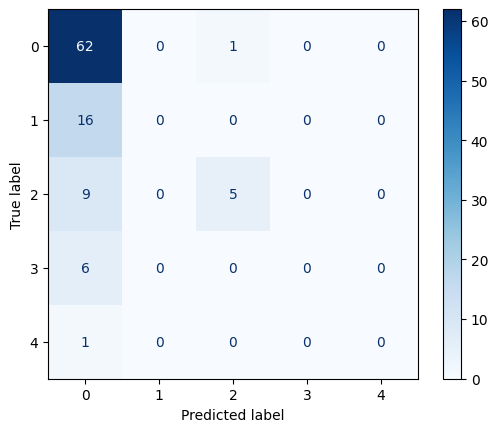

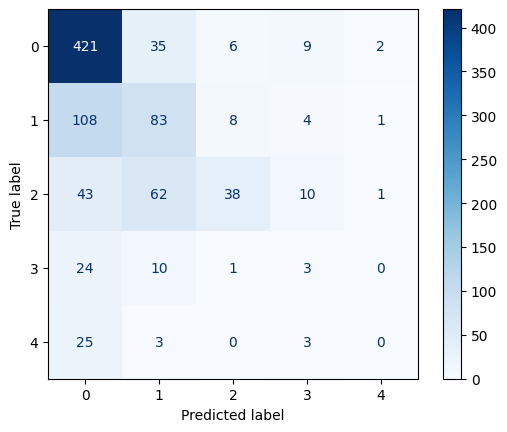

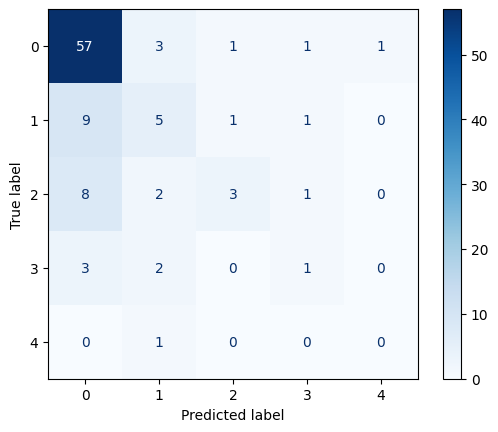

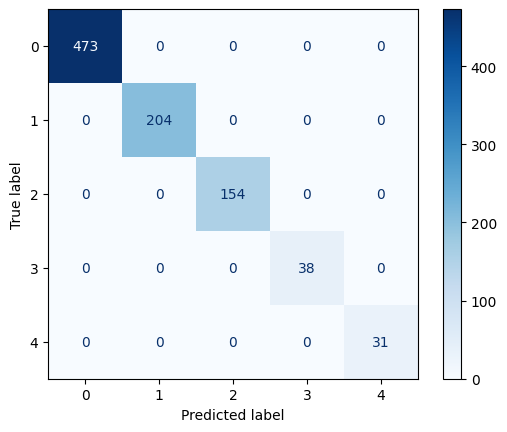

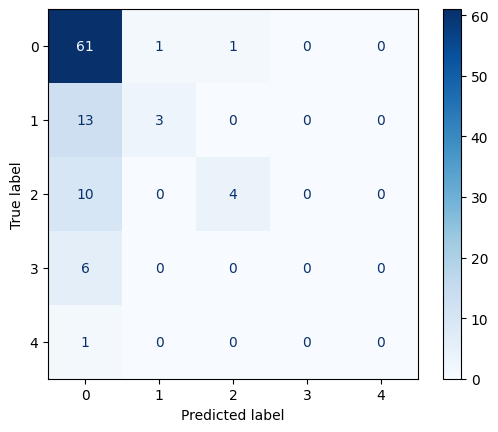

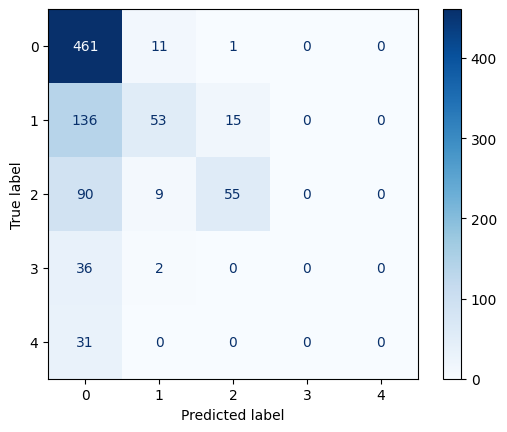

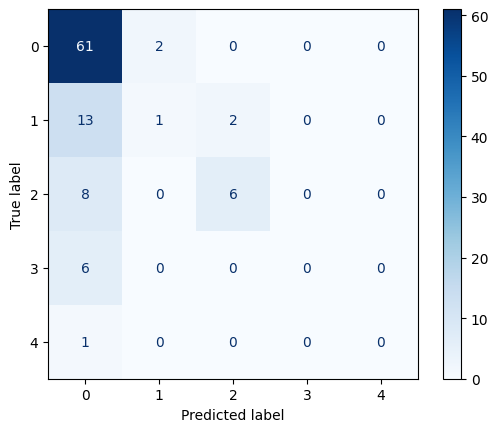

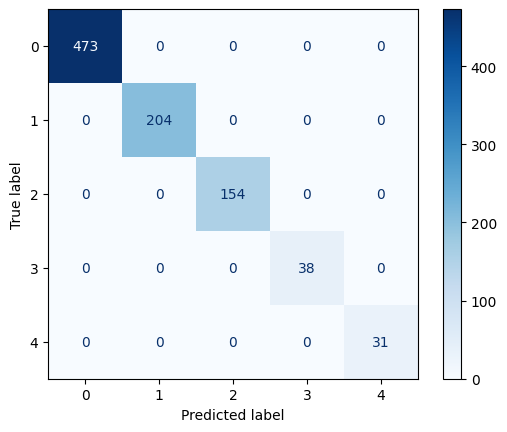

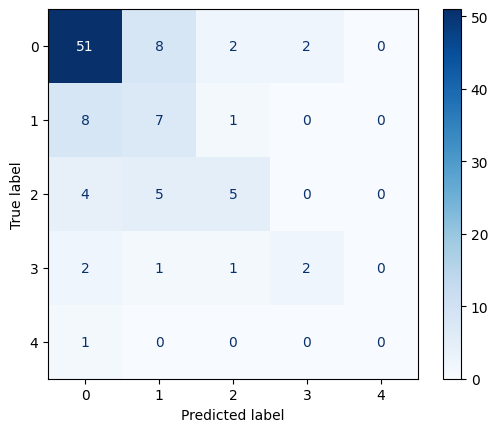

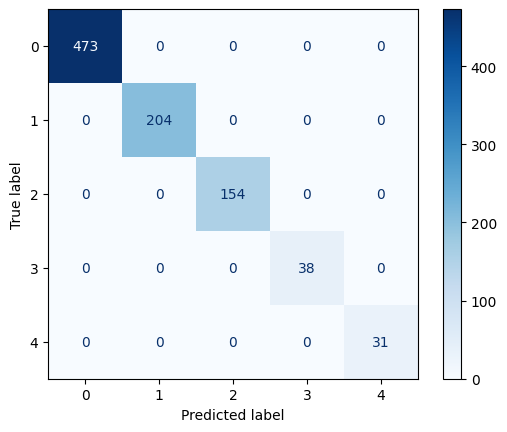

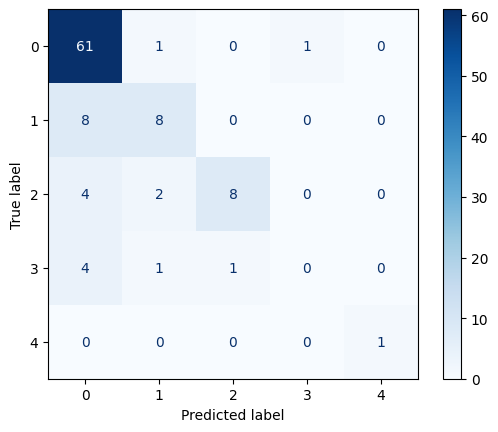

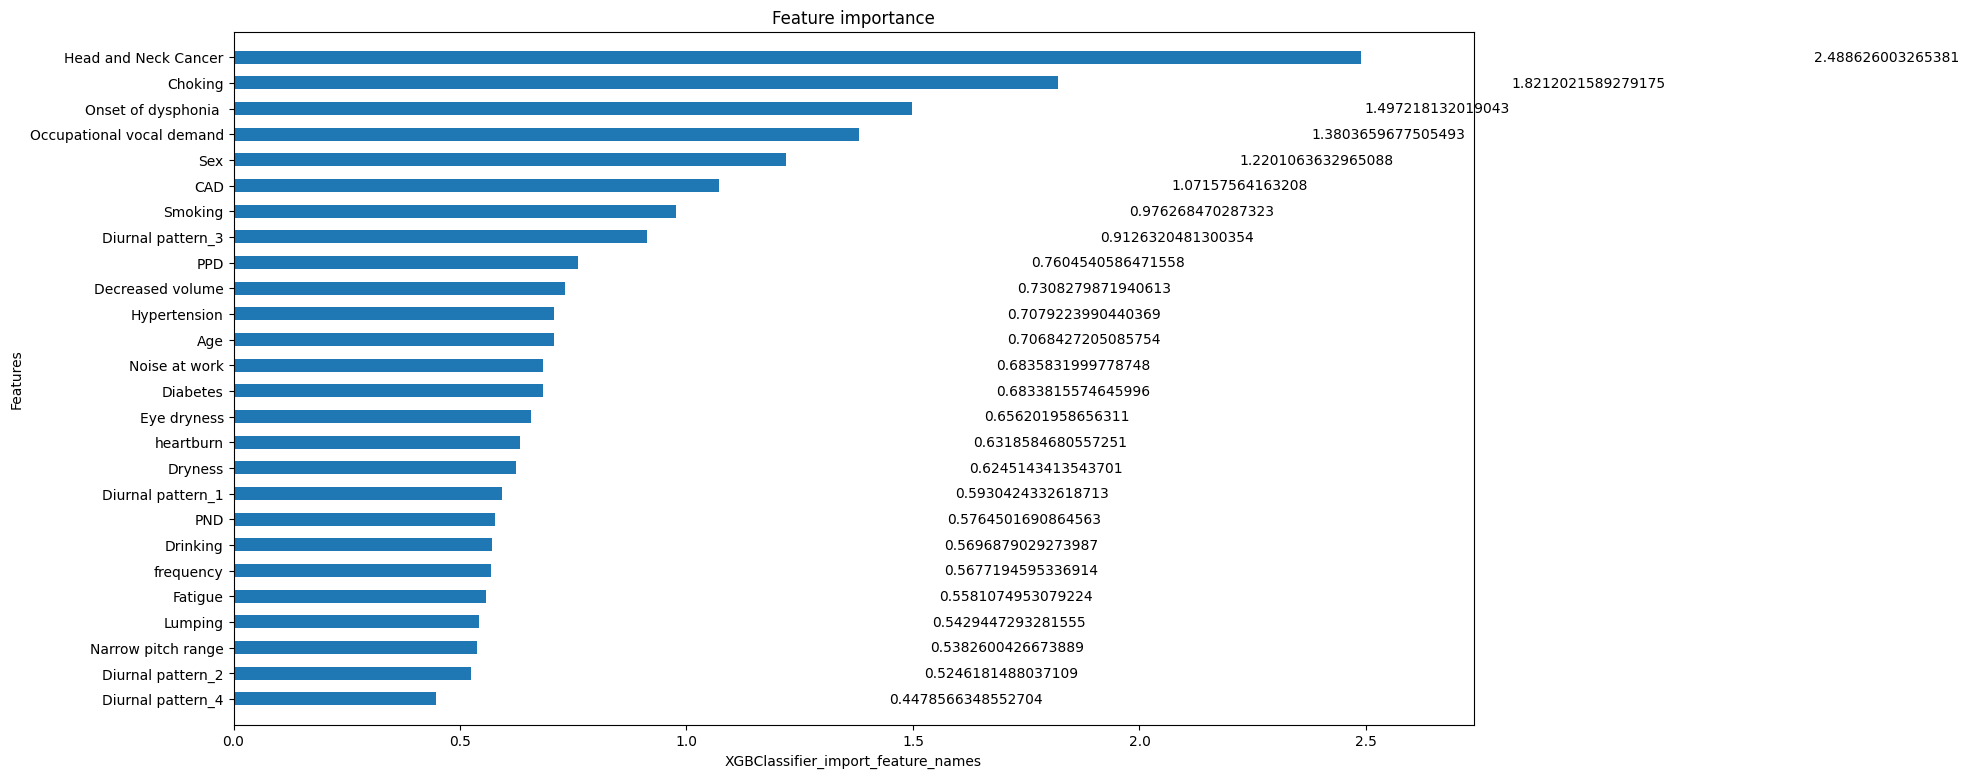

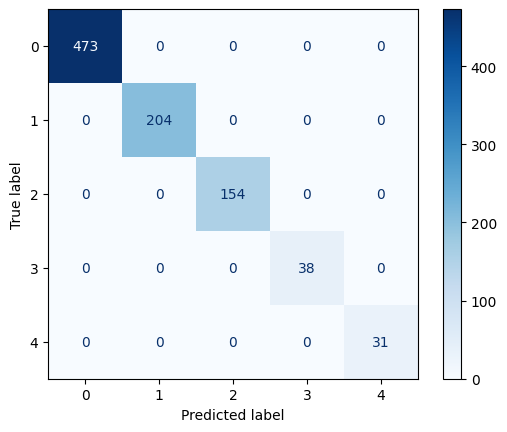

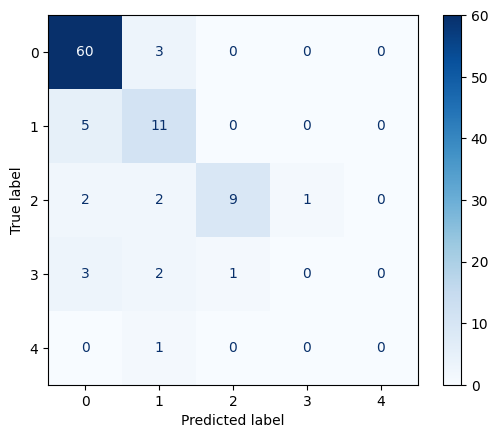

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31639 (\N{CJK UNIFIED IDEOGRAPH-7B97}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27861 (\N{CJK UNIFIED IDEOGRAPH-6CD5}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35745 (\N{CJK UNIFIED IDEOGRAPH-8BA1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20986 (\N{CJK UNIFIED IDEOGRAPH-51FA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/

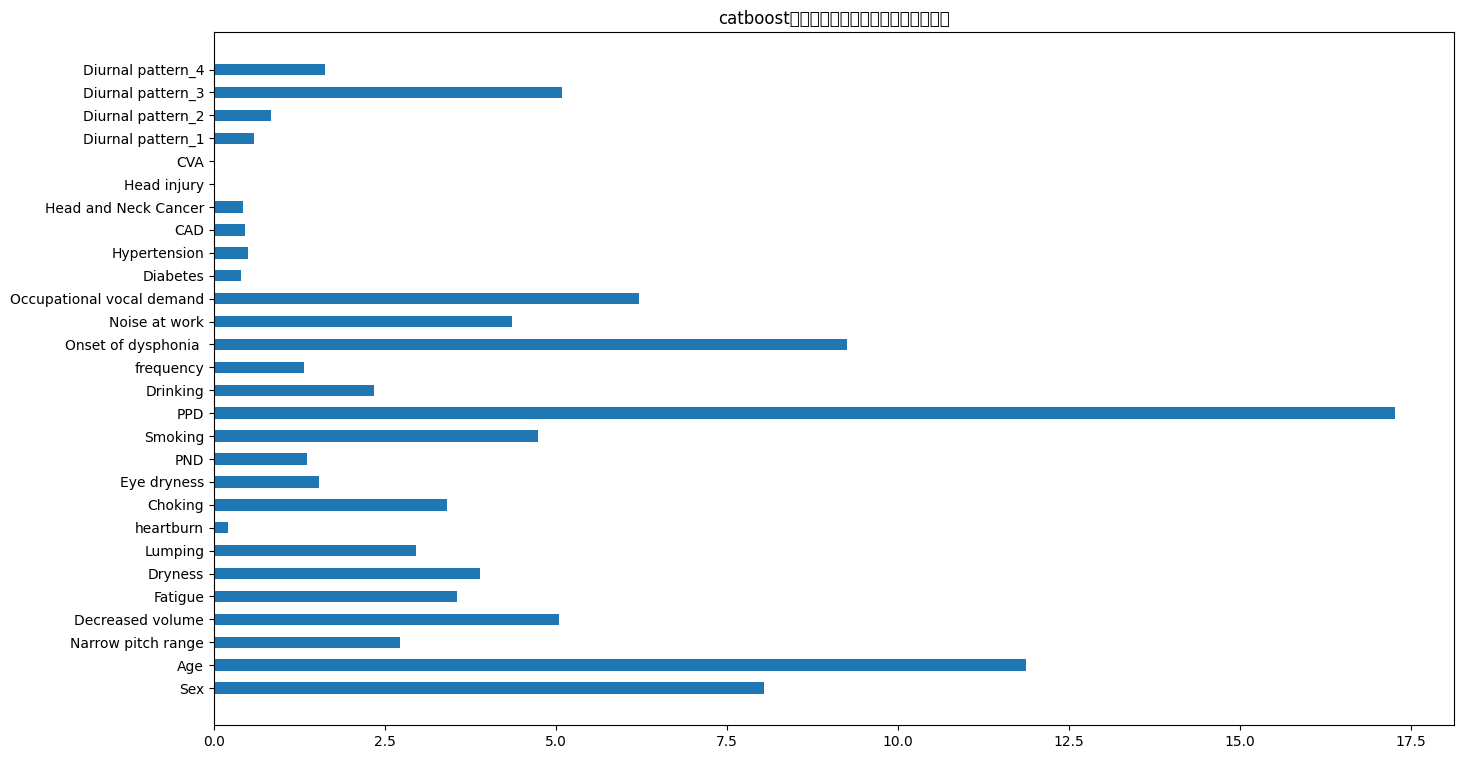

In [ ]:
result=runclf(x_train, y_train, x_test, y_test, training_label, test_label)

In [ ]:
# 刪除不需要的欄位
x_train_drop=x_train.drop(['heartburn', 'Diabetes', 'Hypertension', 'CAD', 'Head injury', 'CVA'],axis=1)
x_test_drop=x_test.drop(['heartburn', 'Diabetes', 'Hypertension', 'CAD', 'Head injury', 'CVA'],axis=1)

In [ ]:
x_train_drop.columns

Index(['Sex', 'Age', 'Narrow pitch range', 'Decreased volume', 'Fatigue',
       'Dryness', 'Lumping', 'heartburn', 'Choking', 'Eye dryness', 'PND',
       'Smoking', 'PPD', 'Drinking', 'frequency', 'Onset of dysphonia ',
       'Noise at work', 'Occupational vocal demand', 'Diabetes',
       'Hypertension', 'CAD', 'Head and Neck Cancer', 'Head injury', 'CVA',
       'Diurnal pattern_1', 'Diurnal pattern_2', 'Diurnal pattern_3',
       'Diurnal pattern_4'],
      dtype='object')

svm
----------training----------
Training UAR(Unweighted Average Recall) : 0.30650179733627064
Training UAR(Unweighted Accuracy) : 0.5822222222222222
----------test----------
Testing UAR(Unweighted Average Recall) : 0.2759920634920635
Testing UAR(Unweighted Accuracy) : 0.63
NB
----------training----------
Training UAR(Unweighted Average Recall) : 0.7162205849399707
Training UAR(Unweighted Accuracy) : 0.09
----------test----------
Testing UAR(Unweighted Average Recall) : 0.6871031746031746
Testing UAR(Unweighted Accuracy) : 0.17
RF
----------training----------
Training UAR(Unweighted Average Recall) : 1.0
Training UAR(Unweighted Accuracy) : 1.0
----------test----------
Testing UAR(Unweighted Average Recall) : 0.26607142857142857
Testing UAR(Unweighted Accuracy) : 0.61
LR
----------training----------
Training UAR(Unweighted Average Recall) : 0.28231888950083206
Training UAR(Unweighted Accuracy) : 0.5244444444444445
----------test----------
Testing UAR(Unweighted Average Recall) : 0.27599

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----------training----------
Training UAR(Unweighted Average Recall) : 1.0
Training UAR(Unweighted Accuracy) : 1.0
----------test----------
Testing UAR(Unweighted Average Recall) : 0.4440476190476191
Testing UAR(Unweighted Accuracy) : 0.79


/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 31639 (\N{CJK UNIFIED IDEOGRAPH-7B97}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 27861 (\N{CJK UNIFIED IDEOGRAPH-6CD5}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 35745 (\N{CJK UNIFIED IDEOGRAPH-8BA1}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 20986 (\N{CJK UNIFIED IDEOGRAPH-51FA}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 19982 (\N{CJK UNIFIED IDEOGRAPH-4E

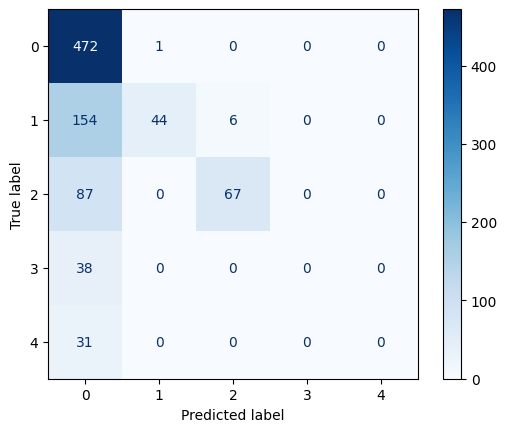

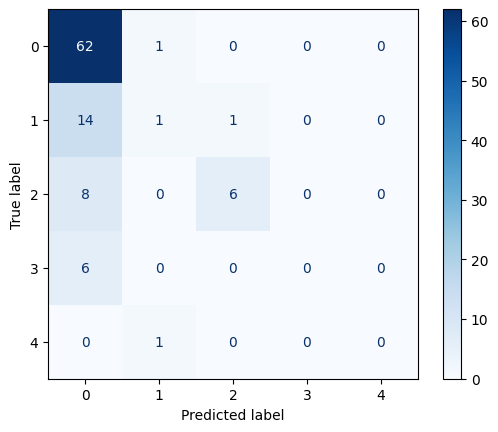

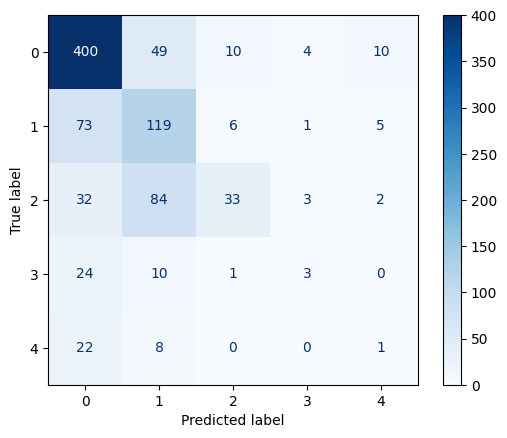

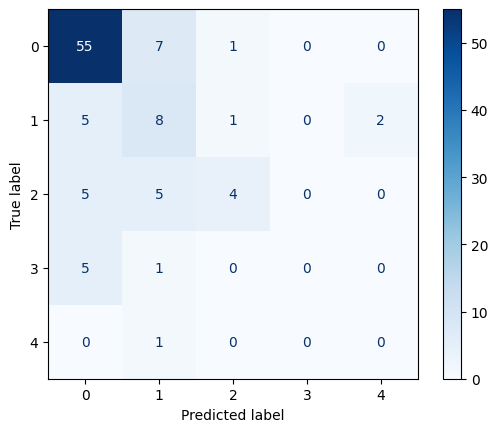

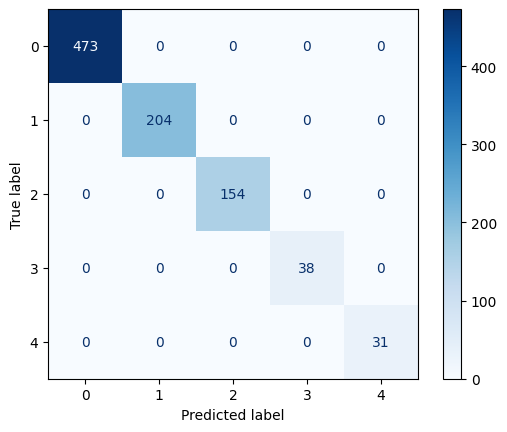

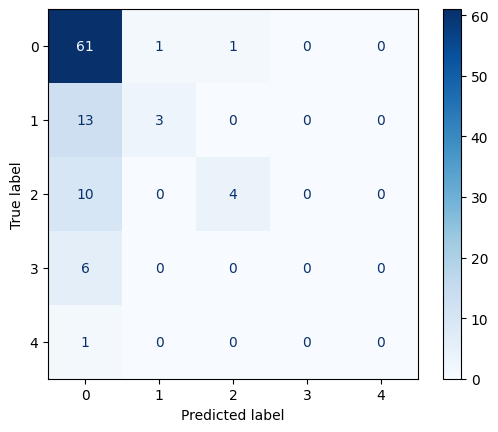

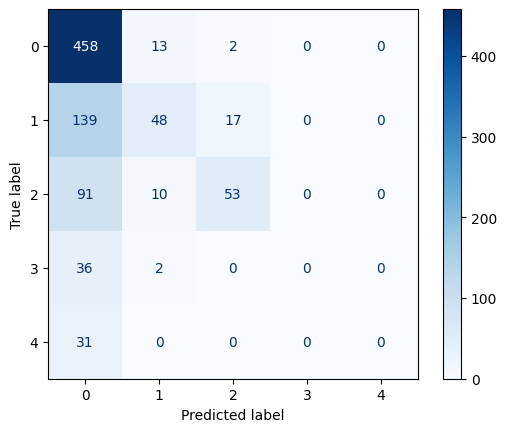

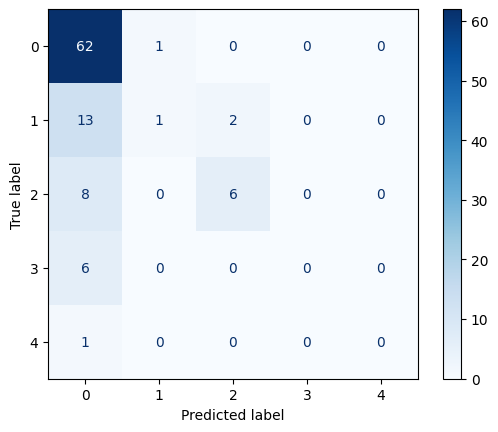

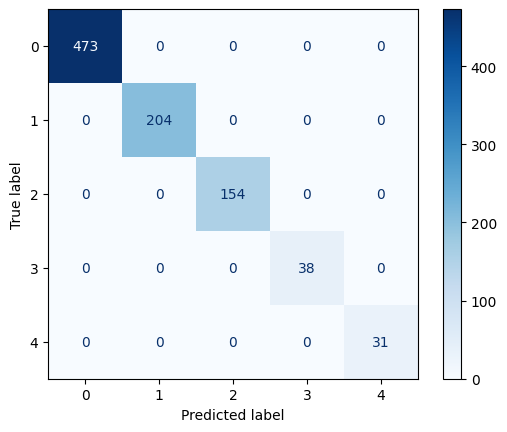

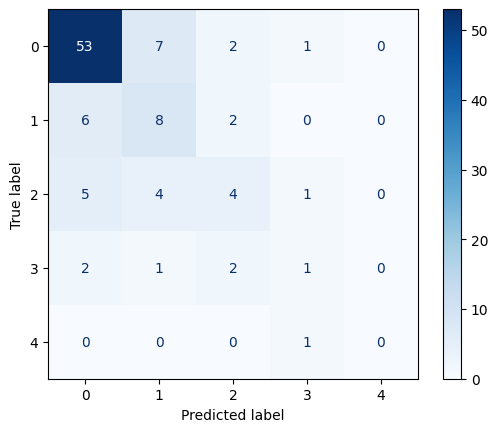

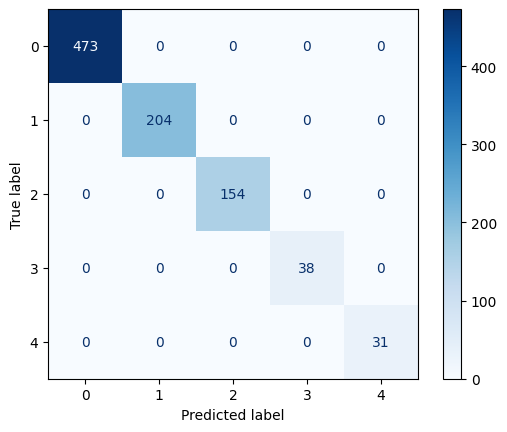

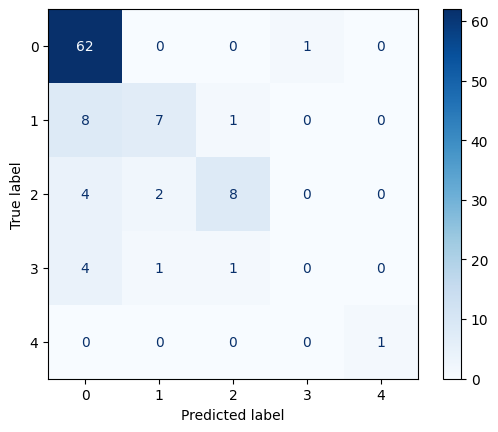

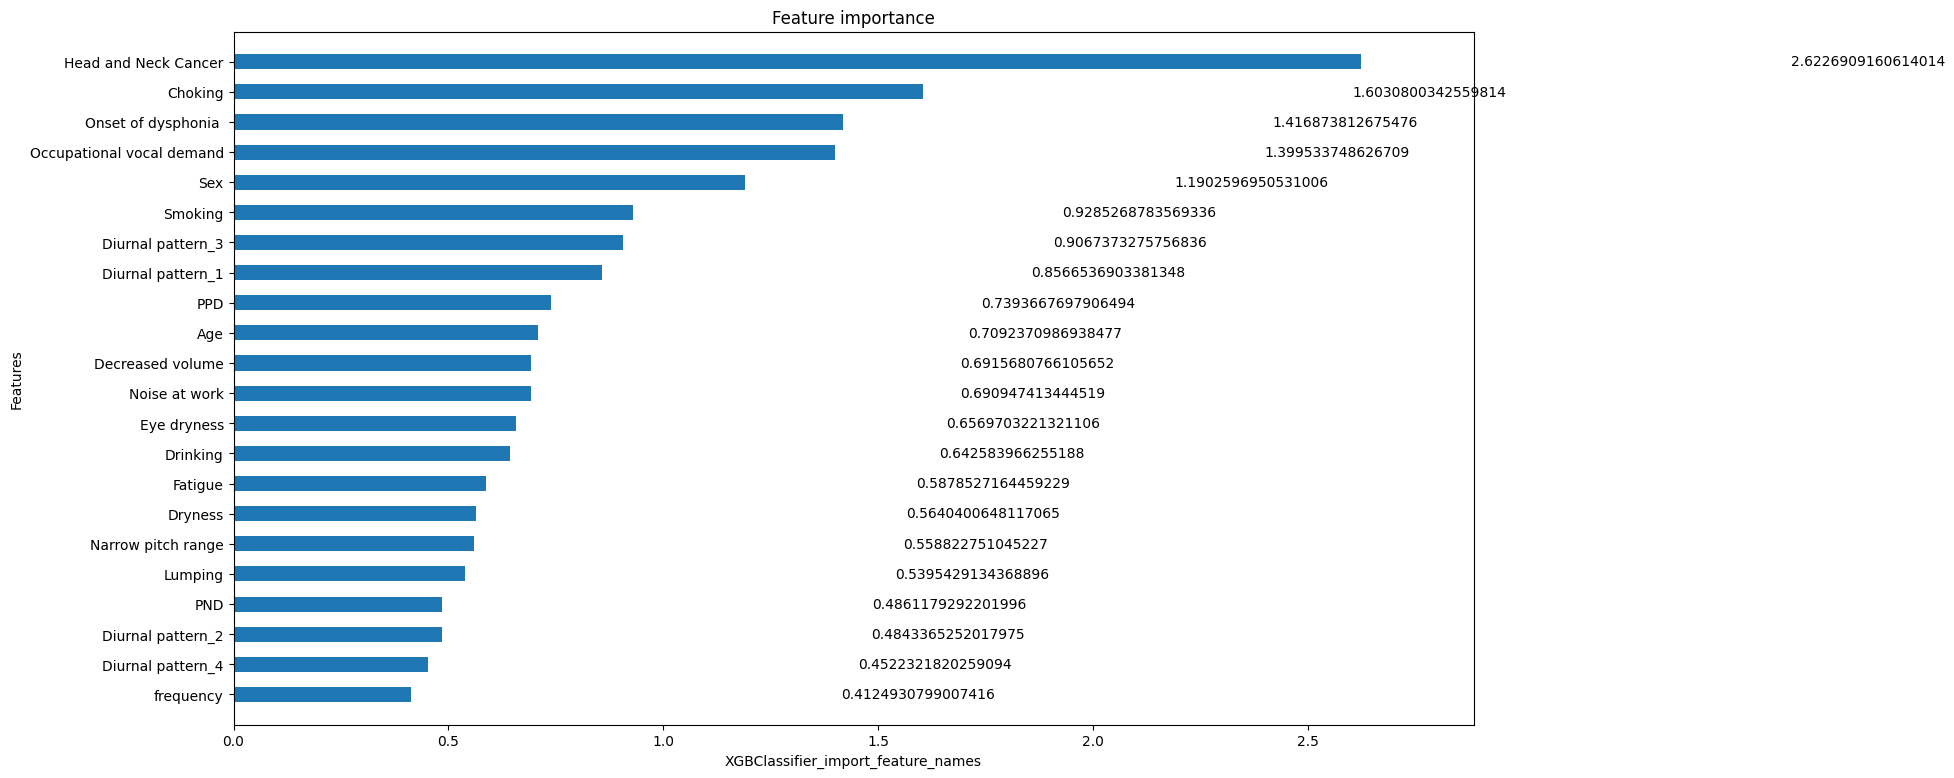

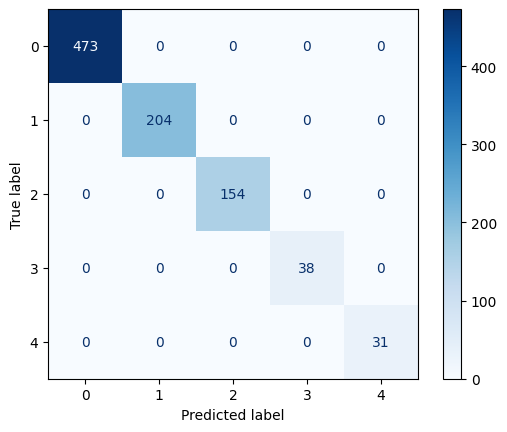

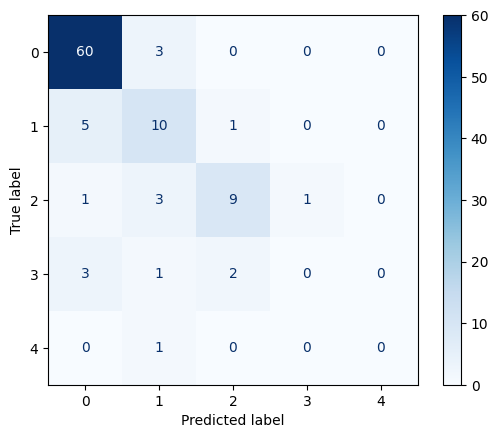

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31639 (\N{CJK UNIFIED IDEOGRAPH-7B97}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27861 (\N{CJK UNIFIED IDEOGRAPH-6CD5}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35745 (\N{CJK UNIFIED IDEOGRAPH-8BA1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20986 (\N{CJK UNIFIED IDEOGRAPH-51FA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/

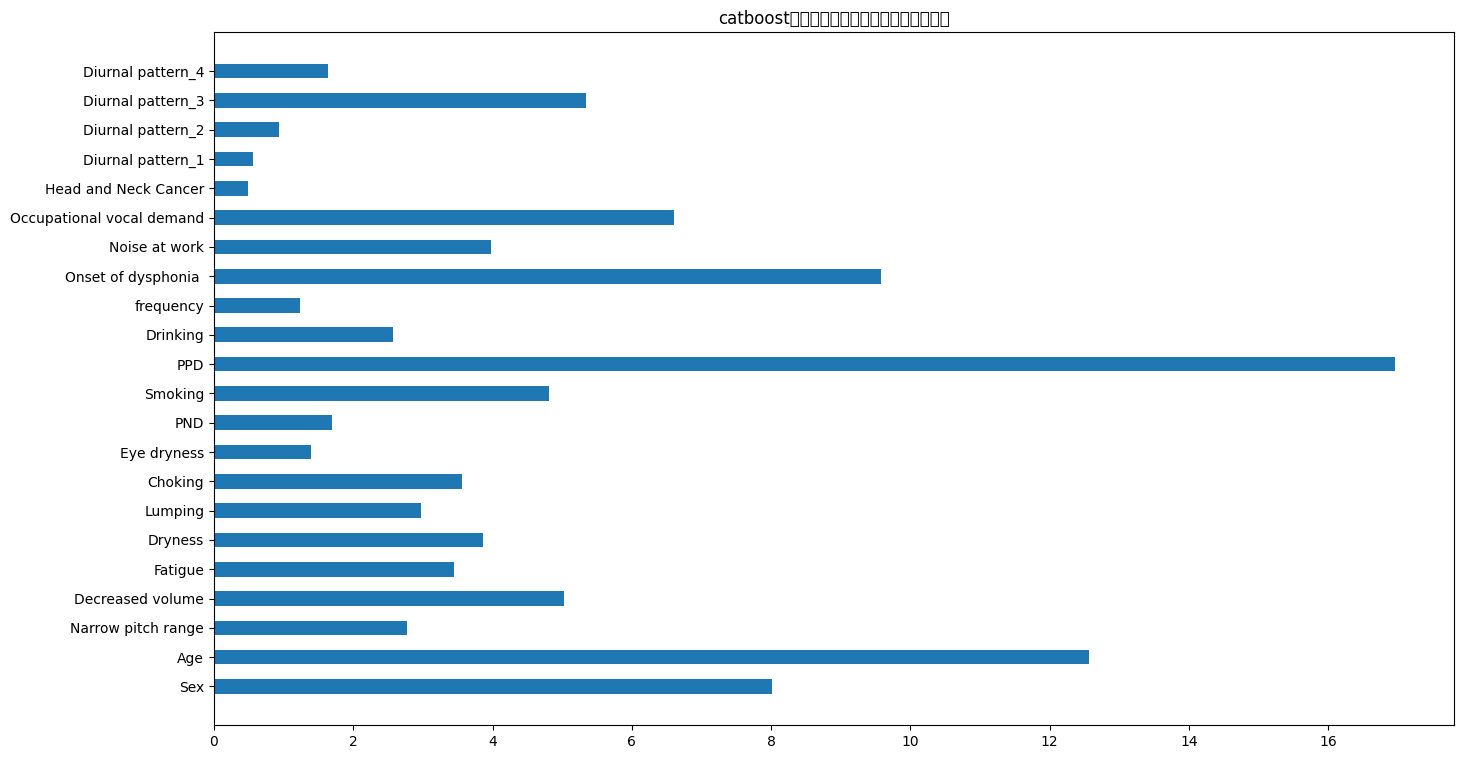

In [ ]:
result_drop=runclf(x_train_drop, y_train, x_test_drop, y_test, training_label, test_label)